# 1) Preparation of constants, paths, libraries

## 1.1) Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/DL Group Project
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/DL Group Project'
/content/drive/.shortcut-targets-by-id/1q1oh4KNPvyl3ACTsbffzNd5ALcMrB42e/DL Group Project
 Lecture_Notebooks/   Project_Code/  'Project Organization'/


## 1.2) Importing libraries and setting paths and constants

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch

In [ ]:
# Additional libaries needed for augmentation:

# Install the newest version of albumentations
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"
import albumentations as A

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-145v35vi
All libraries are successfully installed!


In [ ]:
training_csv_path = 'Project_Code/Data/training.csv'
output_path = 'Project_Code/OutputFolder/ResNet_400epochs'
# output_path = 'Project_Code/OutputFolder/Augmentation'

# learning parameters
BATCH_SIZE = 256
LR = 0.0001
EPOCHS = 400
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 80% training, 20% test
TEST_SPLIT = 0.2

# Size of images
SIZE = 96

# Decide if you want to see an example image during training to visualize the 
# model development:
show_images_during_training = True

## 1.3) Setting fixed seeds and configurations for reproducibility 

In [ ]:
import random

torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

# 2) Prepare Data 

## 2.1) Train-test split


In [ ]:
# train_test_split
def train_test_split(csv_path, split):
    '''
    This function loads the training data set and splits the dataframe into 
    training_samples and valid_samples. 
    output: training_samples, valid_samples (both panda dataframes)
    '''
    df_data = pd.read_csv(csv_path)
    print('Number samples before droping rows with missing values:', len(df_data))
    # drop all rows with missing values
    df_data = df_data.dropna()
    print('Number samples after droping rows with missing values:', len(df_data))

    training_size = np.ceil(0.8 * len(df_data)).astype('int')
    indices = list(range(len(df_data)))

    # split the data into training and validation:
    df_train = df_data.iloc[indices[:training_size]]
    df_test = df_data.iloc[indices[training_size:]]

    print(f"Training sample instances: {len(df_train)}")
    print(f"Validation sample instances: {len(df_test)}")
    return df_train, df_test

In [ ]:
df_train, df_test = train_test_split(training_csv_path, TEST_SPLIT)

Number samples before droping rows with missing values: 7049
Number samples after droping rows with missing values: 2140
Training sample instances: 1712
Validation sample instances: 428


## 2.2) Define functions needed for data augmentation


In the following we have defined three different transformations.

They all have in common that they do with p=1 a [ShiftScaleRotate](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.ShiftScaleRotate) Operation and with p=0.5 a [Horizontale Flip](https://albumentations.ai/docs/api_reference/augmentations/transforms/). (However, even if a ShiftScaleRotate is applied, the parameters of the different operations envolved (shifting, scaling, and rotation) are still drawn randomly, e.g. the angle of the rotation.) 

Additional all three transformations have one specific unique transformation: [Blur](https://albumentations.ai/docs/api_reference/augmentations/transforms/), [Brightness increase and Brightness decrease.](https://albumentations.ai/docs/api_reference/augmentations/transforms/)



In [ ]:
# Create the three transformations we want to use:
transf1 = A.Compose(
    [A.Blur(blur_limit=[1,3], p=1), 
     A.ShiftScaleRotate(rotate_limit=20,scale_limit=0.1, 
                        border_mode=cv2.BORDER_CONSTANT, p = 1),
     A.HorizontalFlip(p=0.5)], 
    keypoint_params=A.KeypointParams(format='xy')
)

transf2 = A.Compose(
    [A.RandomBrightnessContrast(brightness_limit=[0.1,0.25], contrast_limit=0.2,
                                p=1), 
     A.ShiftScaleRotate(rotate_limit=20,scale_limit=0.1, 
                        border_mode=cv2.BORDER_CONSTANT, p = 1),
     A.HorizontalFlip(p=0.5)], 
    keypoint_params=A.KeypointParams(format='xy')
)

transf3 = A.Compose(
    [A.RandomBrightnessContrast(brightness_limit=[-0.25,-0.1], contrast_limit=0.2,
                                p=1), 
     A.ShiftScaleRotate(rotate_limit=20,scale_limit=0.1, 
                        border_mode=cv2.BORDER_CONSTANT, p = 1),
     A.HorizontalFlip(p=0.5)], 
    keypoint_params=A.KeypointParams(format='xy')
)

transformations = [transf1, transf2, transf3]

In [ ]:
def secure_correct_keypoints_ordering(keypoints):
  '''
  This function checks if a flip was applied. If that is the case we have to 
  reorder the keypoint coordinates. 
  To examine this we use the eye center:
  Originally, the first keypoint is the left eye center and the second keypoint
  is the right eye center. Thus, the x-coord of the left eye center
  (keypoints[0,0]) should be bigger than the right eye center (keypoints[1,0]).
  Otherwise, the image was flipped. 
  '''
  if (keypoints[0,0] < keypoints[1,0]):
    re_ordering = [1, 0, 4, 5, 2, 3, 8, 9, 6, 7, 10, 12, 11, 13, 14]
    correct_ordered_keypoints = np.zeros((15,2))
    for i in range(15):
        correct_ordered_keypoints[i] = keypoints[re_ordering[i]]
    return correct_ordered_keypoints
  else:
    return keypoints

In [ ]:
def check_valid_keypoints(keypoints, image_size):
    '''This functions tests if all given keypoints can be used for our model
    training. This includes securing that all keypoints lie within the image
    frame and checking that there are 15 keypoints in total.'''
    enough_keypoints = keypoints.shape[0] == 15
    valid_keypoints = np.logical_and(keypoints.flatten() > 0, keypoints.flatten() < image_size).all()
    return enough_keypoints and valid_keypoints

In [ ]:
def create_augmentedData(orig_image, orig_keypoints, image_size, *transformations, transf_type=None):
  '''This function creates a transformed image and the corresponding new 
  keypoints.'''
  if transf_type == None:
      transf_type = np.random.randint(0,len(transformations))
  
  if len(transformations)-1 < transf_type:
    return None

  transformed = transformations[transf_type](image=orig_image, keypoints=orig_keypoints)
  im = transformed['image']
  keypoints = transformed['keypoints']
  keypoints = np.array(list(map(lambda pair: [pair[0],pair[1]], keypoints)))

  # Check if all the new keypoints lie within the transformed image. 
  if not (check_valid_keypoints(keypoints, image_size)):
    return None

  # In case the transformation included a flip, we have to reorder the keypoints:
  keypoints = secure_correct_keypoints_ordering(keypoints)

  return im, keypoints

## 2.3) Create Datasets and Dataloaders

In [ ]:
class FaceKeypointDataset(Dataset):
  def __init__(self, data, augmentation=False):
    # data is a panda dataframe with the first 30 columns containing the 
    # keypoints and the last column containing the images

    # extract keypoints
    raw_keypoints = data.drop(['Image'], axis=1)
    self.keypoints = []

    # extract images
    self.image_pixels = []
    #for i in tqdm(range(len(data))):
    for i in range(len(data)):
        # first we add the original image and the corresponding keypoints to our lists
        orig_img = np.array(data['Image'].iloc[i].split(' '), dtype='float32')
        orig_img = orig_img.reshape(SIZE, SIZE)
        # rescale image pixels such that all are in the range of 0 and 1
        orig_img = orig_img / 255.0
        self.image_pixels.append(orig_img)
        orig_keypoints = np.array(raw_keypoints.iloc[i],dtype='float32').reshape(-1,2)
        self.keypoints.append(orig_keypoints)

        # secondly, we apply data augmentation to create three additional instance:
        if augmentation:
          for j in range(3):
              # In rare cases, create_augmentedData returns 'None' if some of 
              # the transformed keypoints lie outside of the image
              try:
                new_img, new_keypoints = create_augmentedData(orig_img, orig_keypoints, SIZE, *transformations, transf_type=j)
                self.image_pixels.append(new_img)
                self.keypoints.append(new_keypoints)
              except:
                pass

    # save all images in a numpy array (current shape: (number of instances, 9216))
    self.images = np.array(self.image_pixels, dtype='float32')


  def __len__(self):
      return len(self.images)

  def __getitem__(self, index):
    # reshape image 
    image = self.images[index].reshape(1, SIZE, SIZE)

    # get the corresponding keypoints
    keypoints = self.keypoints[index]

    # we return a dictionary
    return {
        'image': torch.tensor(image, dtype=torch.float),
        'keypoints': torch.tensor(keypoints, dtype=torch.float),
    }

In [ ]:
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointDataset(df_train, augmentation=True)
valid_data = FaceKeypointDataset(df_test, augmentation=False)

# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
test_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

### Let's have a look at the Datasets and the Dataloaders that we have just produced:

In [ ]:
print('Original training size:', len(df_train))
print('Adding our augmented images:', len(train_data))

print('''The test data size hasn't changed:''', len(df_test), 'and', len(valid_data))

Original training size: 1712
Adding our augmented images: 6736
The test data size hasn't changed: 428 and 428


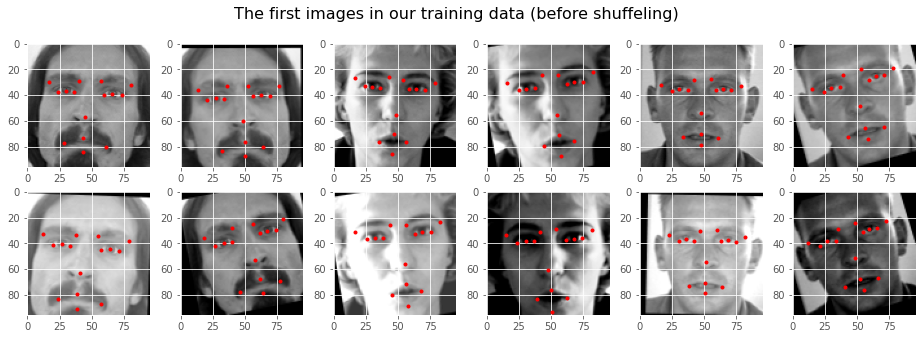

In [ ]:
import operator
from functools import reduce

# Let's have a look at the first three images and their corresponding 
# transformed images

plt.figure(figsize=(16, 5))
plt.suptitle('The first images in our training data (before shuffeling)', fontsize=16)
plt_numbers = [1,2,7,8, 3,4,9,10, 5,6,11,12]

for i in range(12):
  plt.subplot(2,6,plt_numbers[i])
  plt.imshow(train_data[i]['image'].reshape(SIZE, SIZE), cmap='gray')
  plt.plot(train_data[i]['keypoints'][:,0], train_data[i]['keypoints'][:,1], 'r.')
plt.savefig(f"{output_path}/augmentation.png")
plt.show()

# 3) Build the model

In [ ]:
#single_batch = next(iter(train_loader))
#print(single_batch['image'].shape)
#print(single_batch['keypoints'].shape)

In [ ]:
# load additional libraries 
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Residual Block from Dive Into Deep Learning 
# (http://d2l.ai/chapter_convolutional-modern/resnet.html)

class Residual(nn.Module):  
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)
        if self.conv3:
            X = self.conv3(X)
        Y += X

        return F.relu(Y)

In [ ]:
# Define the main model
class FaceKeypointModel(nn.Module):
    def __init__(self):
        super(FaceKeypointModel, self).__init__()

        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding = 'same')
        self.pool = nn.MaxPool2d(2, 2)

        self.blk1 = Residual(32, 64, use_1x1conv=True, strides=2)
        self.blk2 = Residual(64, 128, use_1x1conv=True, strides=2)
        self.blk3 = Residual(128, 256, use_1x1conv=True, strides=2)
        self.blk4 = Residual(256, 512, use_1x1conv=True, strides=2)

        self.fc1 = nn.Linear(512, 256) 
        self.fc2 = nn.Linear(256,30)
    def forward(self, x):
         x = self.conv(x)
         x = self.pool(x)
         x = self.blk1(x)
         x = self.blk2(x)
         x = self.blk3(x)
         x = self.blk4(x)

         # bs is the batch size or respectively the number of instances 
         # simultaneously loaded into the model
         bs, _, _, _ = x.shape 

         # The next step finally transforms the images into 1-dim vectors of lenght 128
         x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)

         # apply a classic linear function
         x = self.fc1(x)
         out = self.fc2(x) 

         return out

# 4) Training the model

In [ ]:
# intialize the model
model = FaceKeypointModel().to(DEVICE)
# we need a loss function which is good for regression like MSELoss
criterion = nn.MSELoss()
# define optimizer:
# (Adam is an alternative for our classic SGD 
# (https://pytorch.org/docs/stable/optim.html))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
def validation(model, val_dataloader):
    model.eval()
    valid_running_loss = 0.0
    counter = 0

    # calculate the number of batches
    num_batches = int(len(val_dataloader.dataset)/val_dataloader.batch_size)
    with torch.no_grad():
        #for i, data in tqdm(enumerate(val_dataloader), total=num_batches):
        for data in val_dataloader:
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            valid_running_loss += loss.item()
            #storing last batch and outputs for the "Actual vs Predicted" Keypoints Comparison Plotting
            last_batch=data
            last_batch_outputs=outputs

    #Getting image, actual keypoints and predicted output keypoints for the first sample of the last batch used for the "Actual vs Predicted" Keypoints Comparison Plotting
    first_sample_image_in_last_val_batch, first_sample_actual_keypoints_in_last_val_batch, first_sample_predcited_keypoints_in_last_val_batch = last_batch['image'][0], last_batch['keypoints'][0], last_batch_outputs[0].cpu()

    valid_loss = valid_running_loss/counter

    #Returns a tuple. Besides the valid loss of the epoch (index 0), we return the image (index 1), actual keypoints index(2) and predicted output keypoints(index 3) for 
    #the first sample of the last batch used for the "Actual vs Predicted" Keypoints Comparison Plotting
    return valid_loss, first_sample_image_in_last_val_batch, first_sample_actual_keypoints_in_last_val_batch, first_sample_predcited_keypoints_in_last_val_batch

In [ ]:
def train(model, train_dataloader, val_dataloader):
    # Set the model in training mode.
    model.train()

    # for each epoch we save the loss of our model over the training and test data
    train_loss = []
    val_loss = []

    # calculate the number of batches
    num_batches = int(len(train_dataloader.dataset)/train_dataloader.batch_size)

    for epoch in range(EPOCHS):
        # We will need the following two variables to compute the loss after each epoch
        train_running_loss = 0.0
        counter = 0
    
        # tqdm prints a dynamically updating progressbar
        # (by defining total=num_batches) we tell tqdm how many iterations it can
        # expect, this will help the progressbar to be more accurate
        # for i, data in tqdm(enumerate(train_dataloader), total=num_batches):
        for data in train_dataloader:
            counter += 1
            # extract the images and keypoints for the given batch of training data
            images, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints (original: torch.Size([256, 15, 2]))
            # new size: torch.Size([256, 30])
            keypoints = keypoints.view(keypoints.size(0), -1)

            # set all gradients to zero before using the model
            optimizer.zero_grad()
            outputs = model(images)
            # compute the loss -> single scalar value
            loss = criterion(outputs, keypoints)
            train_running_loss += loss.item()
            loss.backward()
            optimizer.step()

        # We have computed the MSE-loss for each individual batch. In train_running_loss
        # we have the sum over all these MSE-loss, to get the final mean, we have
        # to devide the result by the number of batches (-> counter)
        train_epoch_loss = train_running_loss/counter
        train_loss.append(train_epoch_loss)

        # compute the loss of the model after the last update step over the validation data:
        validation_results = validation(model, val_dataloader)
        val_epoch_loss = (validation_results[0]) 
        val_loss.append(val_epoch_loss)

        if (epoch+1)%25==0 or epoch==0:
          print(f"\nEpoch {epoch+1} of {EPOCHS}")
          print(f"Train Loss: {train_running_loss/counter:.4f}")
          print(f'Val Loss: {val_epoch_loss:.4f}')

          if show_images_during_training:
            print(f'Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:')
            plt.clf()# clean plot
            plt.imshow(validation_results[1].reshape(SIZE, SIZE), cmap='gray')
            plt.plot(validation_results[2][:,0], validation_results[2][:,1], 'r.')
            plt.plot(validation_results[3][::2], validation_results[3][1::2], 'b.')
            plt.show()

          if epoch==399:
            image_to_save = validation_results[1].reshape(SIZE, SIZE)
            keypoints_true_to_save = validation_results[2]
            keypoints_pred_to_save = validation_results[3]

    return train_loss, val_loss, image_to_save, keypoints_true_to_save, keypoints_pred_to_save


Epoch 1 of 400
Train Loss: 2448.8339
Val Loss: 2573.0559
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


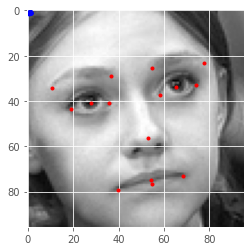


Epoch 25 of 400
Train Loss: 24.4091
Val Loss: 17.9434
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


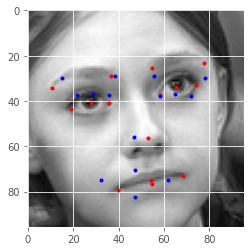


Epoch 50 of 400
Train Loss: 7.4196
Val Loss: 13.7686
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


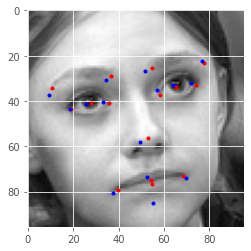


Epoch 75 of 400
Train Loss: 5.2368
Val Loss: 11.1204
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


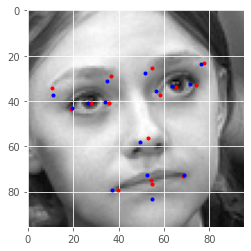


Epoch 100 of 400
Train Loss: 4.1467
Val Loss: 9.8625
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


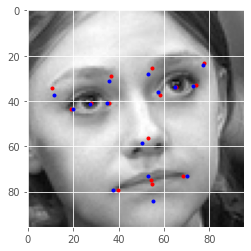


Epoch 125 of 400
Train Loss: 3.8272
Val Loss: 10.6512
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


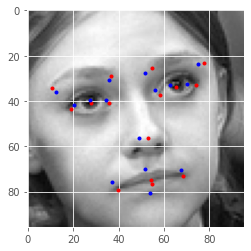


Epoch 150 of 400
Train Loss: 3.4193
Val Loss: 8.3298
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


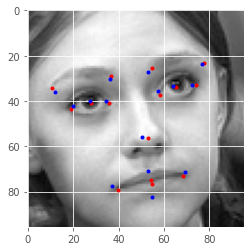


Epoch 175 of 400
Train Loss: 2.5250
Val Loss: 7.2187
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


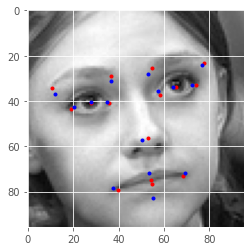


Epoch 200 of 400
Train Loss: 2.5903
Val Loss: 7.2763
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


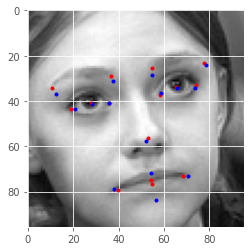


Epoch 225 of 400
Train Loss: 1.9520
Val Loss: 6.5010
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


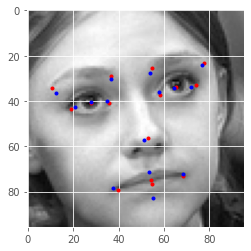


Epoch 250 of 400
Train Loss: 1.9733
Val Loss: 6.3518
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


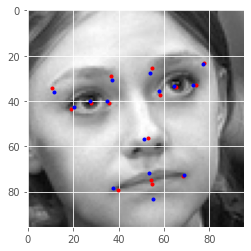


Epoch 275 of 400
Train Loss: 1.5612
Val Loss: 6.1410
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


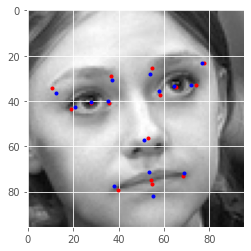


Epoch 300 of 400
Train Loss: 1.4644
Val Loss: 5.7265
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


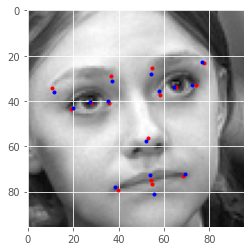


Epoch 325 of 400
Train Loss: 1.4313
Val Loss: 5.6994
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


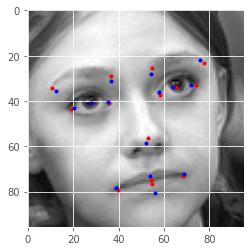


Epoch 350 of 400
Train Loss: 1.1762
Val Loss: 5.7575
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


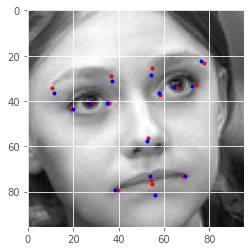


Epoch 375 of 400
Train Loss: 1.0553
Val Loss: 5.3723
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


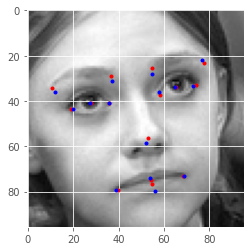


Epoch 400 of 400
Train Loss: 0.9532
Val Loss: 5.3872
Actual (red) vs Predictive (blue) Keypoints Comparison Plotting for the first sample of the last validation batch:


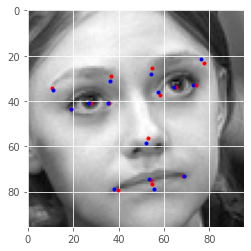

In [ ]:
train_loss, val_loss, image_to_save, keypoints_true_to_save, keypoints_pred_to_save = train(model, train_loader, test_loader)

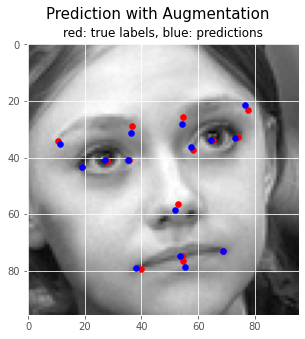

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(image_to_save, cmap='gray')
plt.scatter(keypoints_true_to_save[:,0], keypoints_true_to_save[:,1], color='red')
plt.scatter(keypoints_pred_to_save[::2], keypoints_pred_to_save[1::2], color='blue')
plt.suptitle('Prediction with Augmentation', fontsize=15)
plt.title('red: true labels, blue: predictions', fontsize=12)
# plt.savefig(f"{output_path}/WithAugmentation.png")
plt.show()

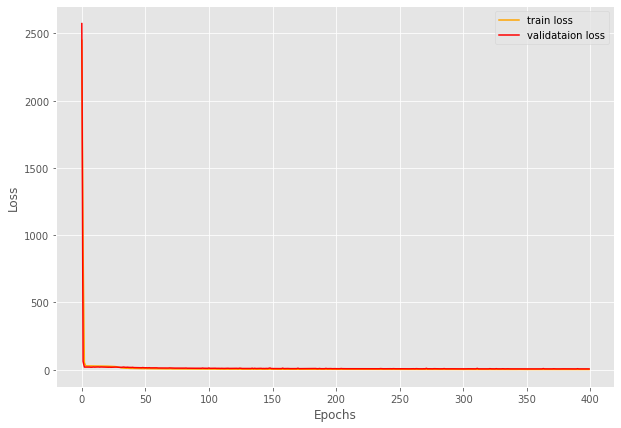

DONE TRAINING


In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"{output_path}/loss.png")
plt.show()
#torch.save({
#            'epoch':EPOCHS,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': criterion,
#            }, f"{output_path}/model.pth")
print('DONE TRAINING')

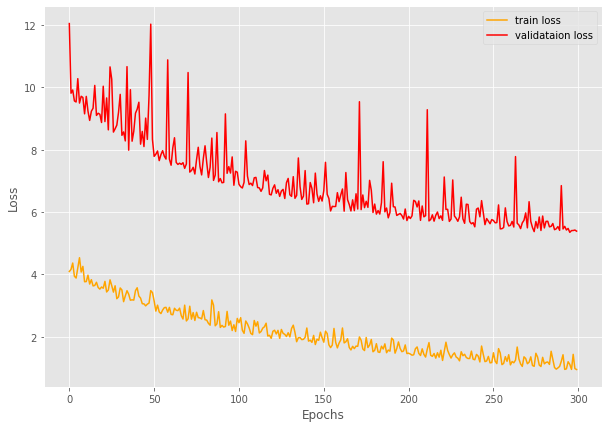

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss[100:], color='orange', label='train loss')
plt.plot(val_loss[100:], color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
sum(p.numel() for p in model.parameters())

5020318

In [ ]:
loss_for_file = np.stack([train_loss,val_loss])
print(loss_for_file.shape)
print(loss_for_file[:,0])
np.savetxt(f"{output_path}/loss_nparrays.csv", loss_for_file, delimiter=",") 

(2, 400)
[2448.83394821 2573.0559082 ]
